In [ ]:
# https://actamachina.com/notebooks/2019/03/28/captcha.html
# https://pytorch.org/get-started/locally/
%pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

In [10]:
from itertools import groupby
from pathlib import Path
from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data.dataset import random_split

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from captcha.image import ImageCaptcha

image = ImageCaptcha()

for chars in range(0, 10000):
    image.write(f'{chars:>04}', f'{chars:>04}.png')

In [3]:
class CaptchaDataset(Dataset):
    """CAPTCHA dataset."""

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = list(Path(root_dir).glob('*'))
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])

        if self.transform:
            image = self.transform(image)

        label_sequence = [int(c) for c in self.image_paths[index].stem]
        return (image, torch.tensor(label_sequence))

    def __len__(self):
        return len(self.image_paths)

In [18]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])

root_dir=r"C:\Users\cidzerda\Documents\GitHub\notebooks\data"
dataset = CaptchaDataset(root_dir=root_dir, transform=transform)

dataloader = DataLoader(dataset, batch_size=10000)

for batch_index, (inputs, _) in enumerate(dataloader):
    print(f'Mean: {inputs.mean()}, Variance: {inputs.std()}')
    input_mean, input_std = inputs.mean(), inputs.std()

Mean: 0.8789486885070801, Variance: 0.14763981103897095


In [32]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((input_mean,), (input_std,)),
])

dataset = CaptchaDataset(root_dir=root_dir, transform=transform)

train_dataset, test_dataset, _ = random_split(dataset, [128*64, 28*64, 10000 - (128*64 + 28*64)])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [33]:
class StackedLSTM(nn.Module):
    def __init__(self, input_size=60, output_size=11, hidden_size=512, num_layers=2):
        super(StackedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(hidden_size, output_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        
    def forward(self, inputs, hidden):
        seq_len, batch_size, input_size = inputs.shape
        outputs, hidden = self.lstm(inputs, hidden)
        outputs = self.dropout(outputs)
        outputs = torch.stack([self.fc(outputs[i]) for i in range(width)])
        outputs = F.log_softmax(outputs, dim=2)
        return outputs, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data 
        return (weight.new(self.num_layers, batch_size, self.hidden_size).zero_(),
                weight.new(self.num_layers, batch_size, self.hidden_size).zero_())
    
net = StackedLSTM().to(device)

In [34]:
criterion = nn.CTCLoss(blank=10)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [24]:
BLANK_LABEL = 10

In [35]:
net.train()  # set network to training phase

epochs = 30
batch_size = 64

# for each pass of the training dataset
for epoch in range(epochs):
    train_loss, train_correct, train_total = 0, 0, 0

    h = net.init_hidden(batch_size)

    # for each batch of training examples
    for batch_index, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        h = tuple([each.data for each in h])

        batch_size, channels, height, width = inputs.shape

        # reshape inputs: NxCxHxW -> WxNx(HxC)
        inputs = (inputs
                  .permute(3, 0, 2, 1)
                  .contiguous()
                  .view((width, batch_size, -1)))

        optimizer.zero_grad()  # zero the parameter gradients
        outputs, h = net(inputs, h)  # forward pass

        # compare output with ground truth
        input_lengths = torch.IntTensor(batch_size).fill_(width)
        target_lengths = torch.IntTensor([len(t) for t in targets])
        loss = criterion(outputs, targets.to(device), input_lengths, target_lengths)

        loss.backward()  # backpropagation
        nn.utils.clip_grad_norm_(net.parameters(), 10)  # clip gradients
        optimizer.step()  # update network weights

        # record statistics
        prob, max_index = torch.max(outputs, dim=2)
        train_loss += loss.item()
        train_total += len(targets)

        for i in range(batch_size):
            raw_pred = list(max_index[:, i].cpu().numpy())
            pred = [c for c, _ in groupby(raw_pred) if c != BLANK_LABEL]
            target = list(targets[i].cpu().numpy())
            if pred == target:
                train_correct += 1

        # print statistics every 10 batches
        if (batch_index + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, ' +
                  f'Batch {batch_index + 1}/{len(train_dataloader)}, ' +
                  f'Train Loss: {(train_loss/1):.5f}, ' +
                  f'Train Accuracy: {(train_correct/train_total):.5f}')

            train_loss, train_correct, train_total = 0, 0, 0

Epoch 1/30, Batch 10/128, Train Loss: 451.34027, Train Accuracy: 0.00000
Epoch 1/30, Batch 20/128, Train Loss: 57.37028, Train Accuracy: 0.00000
Epoch 1/30, Batch 30/128, Train Loss: 30.50413, Train Accuracy: 0.00000
Epoch 1/30, Batch 40/128, Train Loss: 27.99650, Train Accuracy: 0.00000
Epoch 1/30, Batch 50/128, Train Loss: 27.61983, Train Accuracy: 0.00000
Epoch 1/30, Batch 60/128, Train Loss: 27.09844, Train Accuracy: 0.00000
Epoch 1/30, Batch 70/128, Train Loss: 27.06796, Train Accuracy: 0.00000
Epoch 1/30, Batch 80/128, Train Loss: 27.03258, Train Accuracy: 0.00000
Epoch 1/30, Batch 90/128, Train Loss: 27.00482, Train Accuracy: 0.00000
Epoch 1/30, Batch 100/128, Train Loss: 27.01740, Train Accuracy: 0.00000
Epoch 1/30, Batch 110/128, Train Loss: 26.99073, Train Accuracy: 0.00000
Epoch 1/30, Batch 120/128, Train Loss: 26.97791, Train Accuracy: 0.00000
Epoch 2/30, Batch 10/128, Train Loss: 26.97571, Train Accuracy: 0.00000
Epoch 2/30, Batch 20/128, Train Loss: 26.93675, Train Accura

Epoch 19/30, Batch 110/128, Train Loss: 1.01016, Train Accuracy: 0.91094
Epoch 19/30, Batch 120/128, Train Loss: 1.22813, Train Accuracy: 0.90469
Epoch 20/30, Batch 10/128, Train Loss: 0.89698, Train Accuracy: 0.92656
Epoch 20/30, Batch 20/128, Train Loss: 0.95023, Train Accuracy: 0.91094
Epoch 20/30, Batch 30/128, Train Loss: 1.11451, Train Accuracy: 0.88594
Epoch 20/30, Batch 40/128, Train Loss: 1.17770, Train Accuracy: 0.87969
Epoch 20/30, Batch 50/128, Train Loss: 1.24050, Train Accuracy: 0.90312
Epoch 20/30, Batch 60/128, Train Loss: 1.06585, Train Accuracy: 0.91719
Epoch 20/30, Batch 70/128, Train Loss: 0.99312, Train Accuracy: 0.91406
Epoch 20/30, Batch 80/128, Train Loss: 0.95773, Train Accuracy: 0.90938
Epoch 20/30, Batch 90/128, Train Loss: 0.84134, Train Accuracy: 0.93125
Epoch 20/30, Batch 100/128, Train Loss: 1.13749, Train Accuracy: 0.91250
Epoch 20/30, Batch 110/128, Train Loss: 1.09815, Train Accuracy: 0.92031
Epoch 20/30, Batch 120/128, Train Loss: 0.86908, Train Accur

In [37]:
h = net.init_hidden(batch_size)  # init hidden state

net.eval()

test_loss = 0
test_correct = 0
test_total = len(test_dataloader.dataset)

with torch.no_grad():  # detach gradients so network runs faster

    # for each batch of testing examples
    for batch_index, (inputs, targets) in enumerate(test_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])
        batch_size, channels, height, width = inputs.shape

        # reshape inputs: NxCxHxW -> WxNx(HxC)
        inputs = (inputs
                  .permute(3, 0, 2, 1)
                  .contiguous()
                  .view((width, batch_size, -1)))

        outputs, h = net(inputs, h)  # forward pass

        # record loss
        input_lengths = torch.IntTensor(batch_size).fill_(width)
        target_lengths = torch.IntTensor([len(t) for t in targets])
        loss = criterion(outputs, targets.to(device), input_lengths, target_lengths)
        test_loss += loss.item()

        # compare prediction with ground truth
        prob, max_index = torch.max(outputs, dim=2)

        for i in range(batch_size):
            raw_pred = list(max_index[:, i].cpu().numpy())
            pred = [c for c, _ in groupby(raw_pred) if c != BLANK_LABEL]
            target = list(targets[i].cpu().numpy())
            if pred == target:
                test_correct += 1

print(f'Test Loss: {(test_loss/len(test_dataloader)):.5f}, ' +
      f'Test Accuracy: {(test_correct/test_total):.5f} ' +
      f'({test_correct}/{test_total})')

Test Loss: 0.11848, Test Accuracy: 0.92299 (1654/1792)


Target: 5943


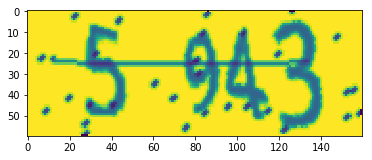

In [38]:
data_iterator = iter(test_dataloader)
inputs, targets = data_iterator.next()

i = 1

image = inputs[i,0,:,:]

print(f"Target: {''.join(map(str, targets[i].numpy()))}")
plt.imshow(image)

In [39]:
inputs = inputs.to(device)

batch_size, channels, height, width = inputs.shape
h = net.init_hidden(batch_size)

inputs = (inputs
          .permute(3, 0, 2, 1)
          .contiguous()
          .view((width, batch_size, -1)))

# get prediction
outputs, h = net(inputs, h)  # forward pass
prob, max_index = torch.max(outputs, dim=2)
raw_pred = list(max_index[:, i].cpu().numpy())

# print raw prediction with BLANK_LABEL replaced with "-"
print('Raw Prediction: ' + ''.join([str(c) if c != BLANK_LABEL else '-' for c in raw_pred]))

pred = [str(c) for c, _ in groupby(raw_pred) if c != BLANK_LABEL]
print(f"Prediction: {''.join(pred)}")

Raw Prediction: ---------------------------------------555-----------------------------------------------9------------------444------------------333----------------------------
Prediction: 5943


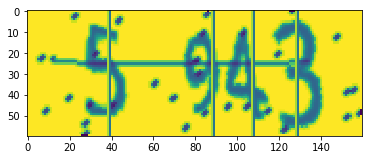

In [40]:
line_mask = [(a == BLANK_LABEL) & (b != BLANK_LABEL) for a, b in zip(raw_pred, raw_pred[1:])]
indices = [i for i, x in enumerate(line_mask) if x]

annotated_image = image.clone()
for index in indices:
    annotated_image[:, index] = 0
    annotated_image[:, index+1] = -2

plt.imshow(annotated_image)